In [1]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage import feature, exposure
from skimage.transform import pyramid_gaussian
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

/home/mike/.conda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mike/.conda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mike/.conda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mike/.conda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mike/.conda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args

In [3]:
def load_data(bShuffle=False):
    X = []
    y = []
    
    vehicle_image_names = glob.glob('data/vehicles/*/*.png')
    for name in vehicle_image_names:
        X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
        y.append(1)
    
    non_vehicle_image_names = glob.glob('data/non-vehicles/*/*.png')
    for name in non_vehicle_image_names:
        X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
        y.append(0)

    if (bShuffle == True):
        X, y = shuffle(X, y)
        
    X_tr, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
        
    return np.array(X_tr), np.array(X_val), np.array(y_train), np.array(y_val)#np.array(X), np.array(y)

In [3]:
X_tr, X_val, y_train, y_val = load_data(bShuffle=True)

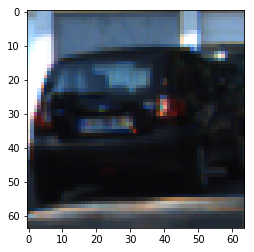

In [4]:
plt.imshow(X_tr[10])

In [5]:
print(X_tr.shape)

(15984, 64, 64, 3)


In [42]:
def get_hist_feature(image, verbous=False):
    r_hist = cv2.calcHist([image],[0],None,[128],[0,256])
    g_hist = cv2.calcHist([image],[1],None,[128],[0,256])
    b_hist = cv2.calcHist([image],[2],None,[128],[0,256])
    
    if(verbous == True):
        rgb_hist = np.concatenate((r_hist, g_hist, b_hist), axis=1)
        color = ('r','g','b')
        for i, col in enumerate(color):
            plt.plot(rgb_hist[:,i],color = col)
            plt.xlim([0,128])
        plt.show()
    
    return np.concatenate((r_hist, g_hist, b_hist), axis=0)[:, 0]

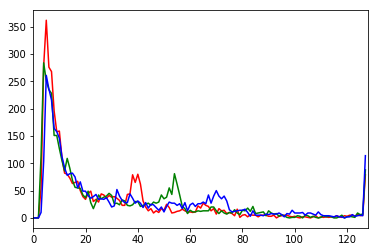

(384,)


In [43]:
hist_feature = get_hist_feature(X_tr[10], True)
print(hist_feature.shape)

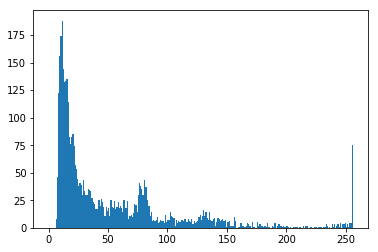

In [44]:
plt.hist(X_tr[10,:,:,0].ravel(),256,[0,256]); plt.show()

In [45]:
def get_spatial_bin_feature(image, size=(16, 16)):
    return cv2.resize(image, size).ravel()

In [46]:
binned = get_spatial_bin_feature(X_tr[10])
print(binned.shape, 16*16*3)

(768,) 768


In [29]:
def get_hog_features(image, size=(32, 32), Verbous=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if(size[0] != image.shape[0] or size[1] != image.shape[1]):
        gray = cv2.resize(gray, size)
    
    # extract Histogram of Oriented Gradients from the image
    (H, hogImage) = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), transform_sqrt=True,
                                block_norm="L1", visualize=True)
    
    if (Verbous == True):
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
        hogImage = hogImage.astype("uint8")
        plt.imshow(hogImage, 'gray')
        #cv2.imshow("HOG Image", hogImage)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    
    return H

(1764,)


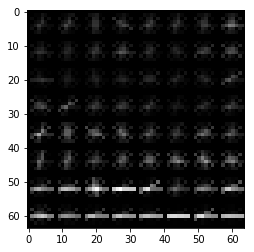

In [47]:
hog_feat = get_hog_features(X_tr[1], size=(64, 64), Verbous=True)
print(hog_feat.shape)
#plt.imshow(X_tr[1])

In [48]:
def get_descriptor(images):
    
    descriptors = []
    
    for img in images:
        img_desc = []
        img_desc.append(get_hist_feature(img))
        img_desc.append(get_spatial_bin_feature(img))
        img_desc.append(get_hog_features(img, size=(64, 64)))
        
        descriptors.append(np.concatenate(img_desc))
    
    return np.array(descriptors)

In [49]:
desc_tr = get_descriptor(X_tr)

In [50]:
print(desc_tr.shape)

(15984, 2916)


In [51]:
print(X_val.shape, y_val.shape)

(1776, 64, 64, 3) (1776,)


In [52]:
desc_val = get_descriptor(X_val)

In [53]:
print(desc_val.shape)

(1776, 2916)


In [54]:
# standardize features with sklearn preprocessing
#Compute the mean and std to be used for later scaling
feature_scaler = StandardScaler().fit(desc_tr)  # per-column scaler
#Perform standardization by centering and scaling
scaled_desc_tr = feature_scaler.transform(desc_tr)

feature_scaler = StandardScaler().fit(desc_val)  # per-column scaler
scaled_desc_val = feature_scaler.transform(desc_val)

In [55]:
clf = LinearSVC(C=1.0)
clf.fit(scaled_desc_tr, y_train)
accuracy_score(y_val, clf.predict(scaled_desc_val))

0.9842342342342343

In [129]:
print('Test Accuracy of SVC = ', round(clf.score(scaled_desc_val, y_val), 4))

Test Accuracy of SVC =  0.9882


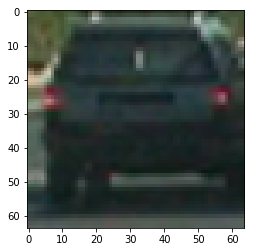

In [56]:
plt.imshow(X_val[11])

In [57]:
print("GT: ", y_val[:15], "Prediction: ", clf.predict(scaled_desc_val[:15]))

GT:  [0 1 0 1 1 1 1 0 0 0 1 1 1 0 0] Prediction:  [0 1 0 1 1 1 1 0 0 0 1 1 1 0 0]


In [58]:
with open('data/svm_trained.pickle', 'wb') as f:
    pickle.dump(clf, f)
with open('data/feature_scaler.pickle', 'wb') as f:
    pickle.dump(feature_scaler, f)
#with open('data/feat_extraction_params.pickle', 'wb') as f:
#    pickle.dump(feat_extraction_params, f)

In [134]:
# load pretrained svm classifier
clf = pickle.load(open('data/svm_trained.pickle', 'rb'))

# load feature scaler fitted on training data
feature_scaler = pickle.load(open('data/feature_scaler.pickle', 'rb'))

# load parameters used to perform feature extraction
#feat_extraction_params = pickle.load(open('data/feat_extraction_params.pickle', 'rb'))

In [135]:
accuracy_score(y_val, clf.predict(scaled_desc_val))

0.9881756756756757

In [2]:
img = cv2.cvtColor(cv2.imread('Lenna.jpg'), cv2.COLOR_BGR2RGB)

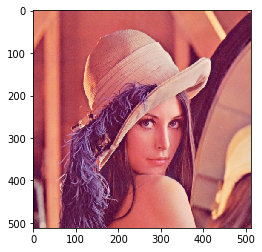

In [5]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

In [7]:
35*80

2800

In [48]:
mag = (gx **2 + gy ** 2) ** (1/2)

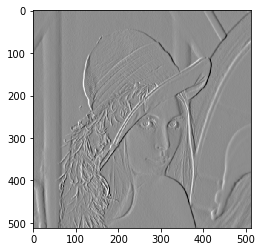

In [49]:
plt.imshow(gx, 'gray')

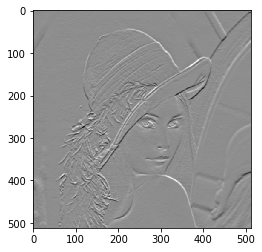

In [7]:
plt.imshow(gy, 'gray')

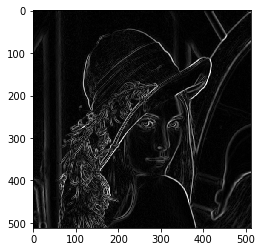

In [8]:
plt.imshow(mag, 'gray')

In [106]:
direction = np.arctan2(gy,gx) * 180 / 3.14

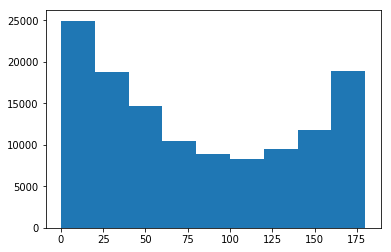

In [107]:
plt.hist(direction.ravel(),9,[0,180]); plt.show()

In [50]:
win = 64
#mag_cells = np.zeros_like(img)
#mask = mag > 0
#print(mask)
#cv2.imshow("mask", np.uint8(mask))
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#mask = np.uint8(mask) * 255
mag_cells = mag
#mag_cells[mask,0] = 255
#mag_cells[mask,1] = 255
#mag_cells[mask,2] = 255
print(mag_cells.shape)
print("mag_cell.shape = ", mag_cells.shape, mag_cells)
for y in range(gray.shape[0] // win):
    for x in range(gray.shape[1] // win):
        tly = y*win
        tlx = x*win
        bry = tly + win
        brx = tlx + win
        cv2.rectangle(mag_cells, (tlx, tly), (brx, bry), [0, 255,0], 1)

cv2.imshow("cells", mag_cells // np.max(mag))
cv2.waitKey(0)
cv2.destroyAllWindows()
        
        

(512, 512)
mag_cell.shape =  (512, 512) [[   0.           62.           18.         ... 1172.
  1608.            0.        ]
 [  14.           51.0881591    18.86796226 ... 1165.72123597
  1622.35631105   20.        ]
 [  22.           44.94441011   31.01612484 ... 1157.79877354
  1621.2248456    12.        ]
 ...
 [  80.          312.77467928  294.70324057 ...  387.57192881
   451.40004431  506.        ]
 [  58.          386.03626773  334.4637499  ...  207.73540863
   232.21541723  262.        ]
 [   0.          390.          326.         ...  116.
   124.            0.        ]]


In [16]:
imgs = pyramid_gaussian(img, downscale=2)

In [20]:
i, im = imgs[0]

TypeError: 'generator' object is not subscriptable

In [28]:
def get_gaussian_pyramid(image, downscale=2, end_shape=(32, 32), verbouse=False):
    img_pyramid = []
    for (i, resized) in enumerate(pyramid_gaussian(image, downscale=downscale)):
        # if the image is too small, break from the loop
        if resized.shape[0] < end_shape[0] or resized.shape[1] < end_shape[1]:
            break

        img_pyramid.append(resized)
        
        if(verbouse == True):
            # show the resized image
            print("Layer {} shape {}".format(i+1,resized.shape))
            cv2.imshow("Layer {}".format(i + 1), resized)
            cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return np.array(img_pyramid)

In [29]:
img_pyr = get_gaussian_pyramid(img, 2, (32,32), True)

Layer 1 shape (512, 512, 3)


/home/mike/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Layer 2 shape (256, 256, 3)
Layer 3 shape (128, 128, 3)
Layer 4 shape (64, 64, 3)
Layer 5 shape (32, 32, 3)


In [30]:
print(img_pyr.shape)

(1, 5)


In [5]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [6]:
(winW, winH) = (128, 128)
test_img = cv2.imread('test_images/test6.jpg')

In [19]:
# loop over the image pyramid
for (i, resized) in enumerate(pyramid_gaussian(test_img, downscale=2)):
    if resized.shape[0] < 64 or resized.shape[1] < 64:
            break
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=64, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
        # WINDOW
        wind = np.zeros((32,32,3))#np.zeros_like(window)
        print(wind.shape)
        gray = cv2.cvtColor(np.uint8(resized), cv2.COLOR_RGB2GRAY)

        # since we do not have a classifier, we'll just draw the window
        clone = resized.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window", clone)
        cv2.waitKey(5)
    cv2.waitKey(0)
cv2.destroyAllWindows()

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32,

/home/mike/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


In [6]:
horizontal_img = cv2.flip(cv2.imread('Lenna.jpg'), 1 )
cv2.imshow("horizontal_img", horizontal_img)
cv2.waitKey(0)
cv2.destroyAllWindows()